# Can Decima identify the eQTL cell type?

In [2]:
import numpy as np
import pandas as pd
import os
import anndata
import scipy
from tqdm import tqdm
from io import StringIO
from collections import defaultdict

from plotnine import *
%matplotlib inline

## Paths

In [3]:
matrix_file = "/gstore/data/resbioai/grelu/decima/20240823/data.h5ad"
eqtl_ad_file = 'scored_sceqtl_vars.h5ad'
save_dir = "/gstore/data/resbioai/karollua/Decima/scborzoi/decima/"
susie_df_file = os.path.join(save_dir,'data/eQTL_processed/susie_df.csv')
eqtl_df_file = 'scored_sceqtls.csv'

## Load data

In [4]:
ad = anndata.read_h5ad(matrix_file)
susie_df = pd.read_csv(susie_df_file)
eqtl_df = pd.read_csv(eqtl_df_file)
eqtl_ad = anndata.read_h5ad(eqtl_ad_file)

# reduce to blood cells
eqtl_ad = eqtl_ad[:,(eqtl_ad.var.tissue == 'blood')].copy()
eqtl_ad.var = eqtl_ad.var.reset_index(drop=True)

## Cell type matching

In [5]:
from eqtl_meta import cell_type_mapping
cell_type_mapping = pd.read_table(StringIO(cell_type_mapping))
all_modelcelltypes = set(cell_type_mapping['model_celltype'])
all_eqtlcelltypes = set(cell_type_mapping['eqtl_celltype'])

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Deduplicate eQTLs so we have one variant-gene pip per cell-type

In [6]:
susie_dedup = susie_df.sort_values(['variant','gene_id','celltype','pip']).drop_duplicates(
    subset=['gene_id','variant','celltype'], keep='last')
len(susie_dedup)

443091

## Subset high-confidence sc-eQTLs

In [7]:
exclude_cell_types = ['dnT cell', 'gdT cell']
susie_dedup = susie_dedup[~susie_dedup.celltype.isin(exclude_cell_types)]

In [8]:
susie_dedup.label = susie_dedup.pip > 0.9

/tmp/ipykernel_17590/2373191554.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [9]:
var_to_target_dict = defaultdict(list)
high_pip_pairs = susie_dedup[susie_dedup.label][['gene_id','variant']].drop_duplicates()
for row in tqdm(susie_dedup.merge(high_pip_pairs, on=['gene_id', 'variant']).itertuples()):
    var_to_target_dict[row.gene_id + ":" + row.variant].append((row.celltype, row.pip))

1614it [00:00, 385205.80it/s]


# associate each variant to on-target and off-target cell-types

In [10]:
rows = []
for k in var_to_target_dict:
    on_target = []
    ambig = []
    off_target = []
    nonexpr = []
    gene_id = k.split(":")[0]
    variant = k.split(":")[1]
    for ct, pip in var_to_target_dict[k]:
        if ct in all_eqtlcelltypes:
            if pip > 0.9:
                on_target += list(cell_type_mapping.query('eqtl_celltype == @ct')['model_celltype'])
            elif pip > 0.1:
                ambig += list(cell_type_mapping.query('eqtl_celltype == @ct')['model_celltype'])

    on_target = set(on_target)
    ambig = set(ambig)
    off_target = all_modelcelltypes - (on_target | ambig)

    rows.append({'gene_id':gene_id, 'variant':variant, 'on_target':list(on_target), 
                 'off_target':list(off_target)})

high_pip_targets = pd.DataFrame(rows)
len(high_pip_targets)

572

## compile celltype average expression for each gene

In [11]:
all_blood_cts = set(eqtl_ad.var.cell_type)
ct_to_gene_to_expr = defaultdict(dict)
for i, ct in tqdm(enumerate(all_blood_cts)):
    ad_sub = ad[(ad.obs.cell_type == ct) & (ad.obs.tissue == "blood")].copy()
    ct_to_gene_to_expr[ct] = {gene_id:ad_sub.X[:, ix].mean(0) for ix, gene_id in enumerate(ad.var.gene_id)}

32it [00:03, 10.38it/s]


## for each off-target celltype, find set of off-targets where the gene is expressed

In [12]:
nonexpr_cut = 1.5
expressed_offtargets = []

for row in high_pip_targets.itertuples():
    nonexpr_offs = []
    for ct in row.off_target:
        if ct_to_gene_to_expr[ct][row.gene_id] < nonexpr_cut:
            nonexpr_offs.append(ct)
    new_offs = list(set(row.off_target).difference(nonexpr_offs))
    expressed_offtargets.append(new_offs)

high_pip_targets['expressed_off_target'] = expressed_offtargets
high_pip_targets = high_pip_targets[high_pip_targets.expressed_off_target.apply(len) > 0]
len(high_pip_targets)

513

## make cell type averaged eqtl data

In [13]:
new_X = np.zeros((len(eqtl_ad.obs), len(all_blood_cts)))
new_refs = np.zeros((len(eqtl_ad.obs), len(all_blood_cts)))
var_rows = []

for i,ct in enumerate(all_blood_cts):
    var_rows.append({'cell_type':ct})
    sub = eqtl_ad[:,eqtl_ad.var.cell_type == ct]
    new_X[:,i] = np.abs(sub.X.mean(1))
    new_refs[:,i] = sub.layers['ref_expr'].mean(1)

eqtl_avg = anndata.AnnData(new_X, obs=eqtl_ad.obs, var=pd.DataFrame(var_rows), layers={'ref_expr':new_refs})
eqtl_avg.shape

/opt/conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


(18171, 32)

In [14]:
eqtl_avg = eqtl_avg[:, eqtl_avg.var.cell_type.isin(all_modelcelltypes)]
eqtl_avg.shape

(18171, 15)

## Compute scores in on-target and off-target cell types

In [15]:
def extract_onofftarget_scores(row, eqtl_ct=eqtl_avg):
    variant = row['variant']
    gene_id = row['gene_id']
    eqtl_var = eqtl_ct[(eqtl_ct.obs.variant == variant) & (eqtl_ct.obs.gene_id == gene_id)].copy()
    ontarget_score = np.abs(eqtl_var[:,eqtl_var.var.cell_type.isin(row['on_target'])].X.mean())
    offtarget_score = np.abs(eqtl_var[:,eqtl_var.var.cell_type.isin(row['expressed_off_target'])].X.mean())
    return ontarget_score, offtarget_score

In [16]:
high_pip_targets[['High PIP cells', 'Other cells with expression']] = high_pip_targets.apply(
    lambda row: extract_onofftarget_scores(row), axis=1).to_list()

In [17]:
len(high_pip_targets)

513

## Test

In [18]:
print(scipy.stats.wilcoxon(high_pip_targets['High PIP cells'],high_pip_targets['Other cells with expression']))

WilcoxonResult(statistic=np.float64(48114.0), pvalue=np.float64(1.1516302871814622e-07))


## Visualize

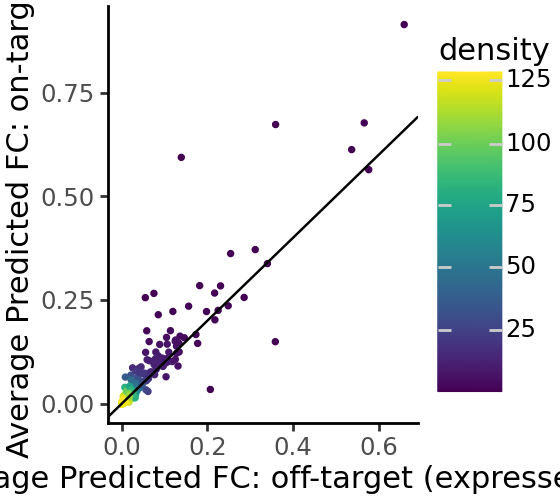

In [19]:
(
    ggplot(high_pip_targets, aes(x='Other cells with expression', y = 'High PIP cells')) +\
    geom_pointdensity(size=.5) + theme_classic() + theme(figure_size=(2.8, 2.5)) 
    + geom_abline(intercept=0, slope=1)
    + ylab("Average Predicted FC: on-target")
    + xlab("Average Predicted FC: off-target (expressed)")
)

## Compute accuracy

In [20]:
np.mean(high_pip_targets['High PIP cells'] > high_pip_targets['Other cells with expression'])

np.float64(0.5497076023391813)

In [21]:
high_pip_targets['max_effect'] = high_pip_targets.variant.apply(lambda x: np.abs(eqtl_avg[eqtl_avg.obs.variant==x].X).max())

In [22]:
high_pip_targets_effect = high_pip_targets[high_pip_targets['max_effect'] > 0.01]

In [23]:
np.mean(high_pip_targets_effect['High PIP cells'] > high_pip_targets_effect['Other cells with expression'])

np.float64(0.6743119266055045)